In [1]:
import os
import urllib.request

os.makedirs('./data', exist_ok = True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

print('Execution Complete')

Execution Complete


In [2]:
# function needed by downstream code...

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

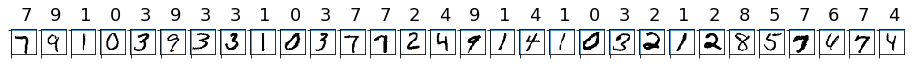

In [3]:
# To help the model to converge faster , you shrink the intensity values (X) from 0-255 to 0-1
X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

# Display some images...
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [1]:
from azureml.core import Workspace,Experiment ,Run
ws = Workspace.get(name='###',
                      subscription_id='####', 
                      resource_group='###' 
                     )

In [2]:
ws.get_details()

In [6]:
from azureml.core import Workspace,Experiment ,Run

#Create an experiment
experiment = Experiment(workspace = ws, name = "my-third-experiment")

In [7]:
from azureml.train.automl import AutoMLConfig
import logging

automl_config = AutoMLConfig(task = 'regression',
                             iteration_timeout_minutes = 6,
                             iterations = 3,
                             primary_metric = 'spearman_correlation',
                             n_cross_validations = 5,
                             debug_log = 'automl.log',
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train)

print('Execution Complete')

Execution Complete


In [8]:
local_run = experiment.submit(automl_config, show_output = True)

print('Execution Complete')

Running on local machine
Parent Run ID: AutoML_f017803d-31e3-40ac-8445-bc9bde1fe990
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   MaxAbsScaler RandomForest                      100.0000    0:04:42       0.7964    0.7964
         1   StandardScalerWrapper DecisionTree             100.0000    0:01:26       0.8059    0.8059
         2   Ensemble                                       100

In [9]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [10]:
best_run, fitted_model = local_run.get_output()

print(best_run)
print(fitted_model)

Run(Experiment: my-third-experiment,
Id: AutoML_f017803d-31e3-40ac-8445-bc9bde1fe990_2,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('RandomForest', Pipeline(memory=None,
     steps=[('MaxAbsScaler', MaxAbsScaler(copy=True)), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.4,...          flatten_transform=None,
               weights=[0.3333333333333333, 0.3333333333333333]))])


In [11]:
ws.delete(delete_dependent_resources=True)